# Experimental training

This notebook outlines the different steps for experimenting with different pre-trained models and different hyperparameters in order to find the best performing configuration (and model) for this research. The selected model will then be validated using as training data both the train and validation sets and it will be tested on the test set.

In this phase I am using the the `datasets`, `trasformers`, and `evaluate` libraries from 🤗 Hugging Face and the Weights & Biases integration to track the experiments.

> ! Specifically, given the complexity of the threeway classification, the experiments are performed on a **binary classification**: the two classes "dubious" and "sensitive" are merged in the class "sensitive".
The dataset created during the two previous Jupyter Notebooks, therefore, should be modified by transferring the images of the folder "dubious" into the folder "sensitive" (of course, this should be done for all three splits).

## Table of contents
1. [Loading the dataset](#loading-the-dataset)
    - [Dataset inspection](#dataset-inspection-optional), optional phase, just useful to see a few practical examples from the dataset
2. [Preprocessing](#preprocessing), for preparing input features for the chosen vision model
3. [Collation and evaluation](#collation-and-evaluation), for defining the collate function and the evaluation metrics
4. [Training parameters](#training-parameters), loading a pretrained model and defining the hyperparameters
5. [Train and evaluate](#train-and-evaluate)
6. [Inference](#inference), to compute and save the inference matrices

In [1]:
# ---- INSTALL LIBRARIES
""" !pip install -U datasets
!pip install transformers evaluate
!pip install accelerate -U
!pip install transformers[torch]
!pip install wandb"""

# ---- IMPORT LIBRARIES
# Weights & Biases setup
import wandb
import os
# Loading dataset
from datasets import load_dataset
# Preprocessing
from transformers import AutoImageProcessor
# Collation and evaluation
import torch
import torch.nn as nn
import evaluate
import numpy as np
# Training parameters
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
# Plot confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay
#import matplotlib.pyplot as plt 


In [2]:
# ---- LOGIN TO WEIGHTS & BIASES TO PLOT LOSSES
wandb.login()
%env WANDB_PROJECT=binary-classification-rcm
%env WANDB_WATCH=all
%env WANDB_SILENT=true

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ombrini. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=binary-classification-rcm
env: WANDB_WATCH=all
env: WANDB_SILENT=true


## Loading the dataset
Before performing any sort of processing on the dataset, we first **load it**.

Given the big dimensions of this project's image dataset (33,2 GB), the loading is done in **streaming mode** to avoid disk memory issues. This means that the result will be an `IterableDataset` object: in this type of dataset the data is read progressively from the local files as we iterate over it (this of course means that data is also accessed and processed differently than a normal `Dataset` object, more of this in the [HF documentation](https://huggingface.co/docs/datasets/about_mapstyle_vs_iterable)).

> When reproducing this code, be careful and follow the instructions in the previous Jupyter Notebooks, especially [2_dataset_creation.ipynb]('./2_dataset_creation.ipynb'), at the end of which you will have the folder based dataset loaded through the `load_dataset` function from the 🤗HF library `datasets`


In [3]:
# ---- LOADING THE DATASET

train_ds = load_dataset('imagefolder', data_dir='./dataset_binary/', split='train', streaming=True)
validation_ds = load_dataset('imagefolder', data_dir='./dataset_binary/', split='validation', streaming=True)

Resolving data files:   0%|          | 0/1773 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/380 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1773 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/380 [00:00<?, ?it/s]

### Dataset inspection (optional)
During the inspection of the dataset we can check its type, features (the internal structure of the dataset), and also see some data point examples.

In particular, we can see that the feature `'label'` is a ClassLabel feature. From the [documentation](https://huggingface.co/docs/datasets/v2.15.0/about_dataset_features):
> The ClassLabel feature informs 🤗 Datasets the label column contains three classes. The classes are labeled `dubious`, `not-sensitive`, and `sensitive`. Labels are stored as integers in the dataset. When you retrieve the labels, `ClassLabel.int2str()` and `ClassLabel.str2int()` carries out the conversion from integer value to label name, and vice versa.

In [4]:
# ---- DATASET INSPECTION

print("""train_ds
      type:\t{type}
      .features:\t{features}""".format(type=train_ds, features=train_ds.features))


train_ds
      type:	IterableDataset({
    features: ['image', 'label'],
    n_shards: 1773
})
      .features:	{'image': Image(decode=True, id=None), 'label': ClassLabel(names=['dubious', 'not-sensitive', 'sensitive'], id=None)}


In [5]:
# ---- CHECKING CONVERSION FROM INTEGER VALUE TO LABEL NAME

labels = train_ds.features['label']

x = labels.int2str(0)
y = labels.int2str(1)
# z = labels.int2str(2) # To be used only for a threeway classification 

print("Integer '0' is label '{x}'\nInteger '1' is label '{y}'".format(x=x, y=y)) # \nInteger '2' is label '{z}' + z=z

Integer '0' is label 'dubious'
Integer '1' is label 'not-sensitive'


<class 'dict'>
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x593 at 0x2060FC1C250>, 'label': 0}
dubious


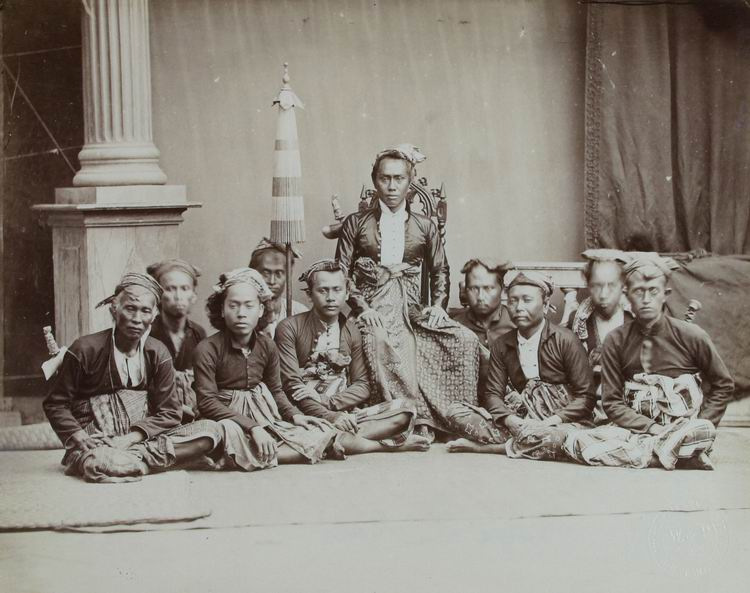

<class 'dict'>
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x561 at 0x2060FC9D490>, 'label': 0}
dubious


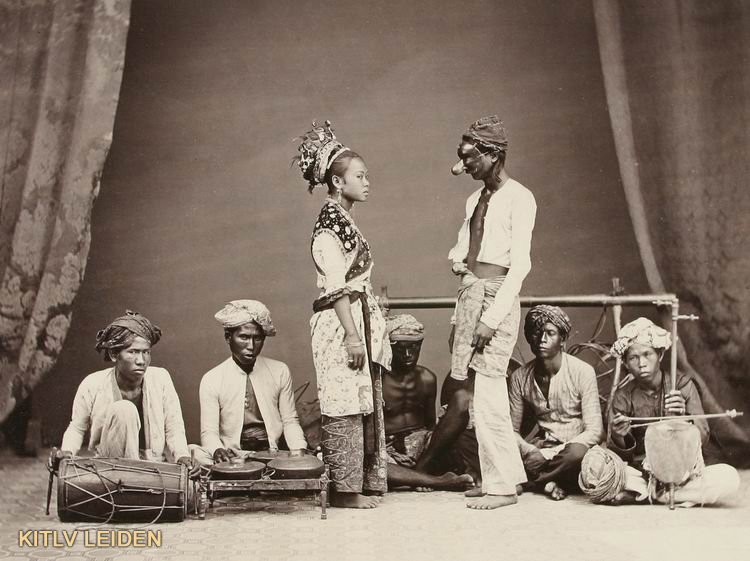

In [6]:
# ---- DATA POINT EXAMPLES

# To see a data point example we have to access it using a for loop to load the data progressively as we iterate over the dataset -> this way, only a small fraction of examples is loaded in memory, and we don't write anything on disk

# We can also 'take' the first n elements and display those (! ATTENTION: the take() function will create a new IterableDataset with only the first n elements)

examples = list(train_ds.take(2))

for item in examples:
    print(type(item))    # <class 'dict'>
    print(item) # {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=5315x3955 at 0x161828B6D50>, 'label': 0}
    # Show the image and its label
    print(labels.int2str(item['label']))
    display(item['image'])



## Preprocessing
Pre-trained models need the input data to be appropriately preprocessed in order to *understand it*: this step helps to ensure that the data is in a format that the algorithm can understand and that it is free of errors or outliers that can negatively impact the model's performance.

In particular, the `AutoImageProcessor` module allows us to **load the appropriate image processor for the specific model** we are using (specified in the `checkpoint` variable): this `image_processor` will prepare input features for vision models and post processing their outputs.
This includes transformations such as resizing, normalization, and conversion to PyTorch, TensorFlow, Flax and Numpy tensors, but may also include model specific post-processing such as converting logits to segmentation masks.

The model we will be experimenting with is [**ResNet**](https://huggingface.co/docs/transformers/v4.35.2/model_doc/resnet):
- [Checkpoint](https://huggingface.co/microsoft/resnet-50): 'microsoft/resnet-50'

After loading the appropriate image processor, we apply the transformations to the whole dataset by mapping it!

In [7]:
# ---- LOAD IMAGE PROCESSOR

checkpoint = 'microsoft/resnet-50' 
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [8]:
# ---- APPLY TRANSFORMATIONS

def transform(example):
    inputs = image_processor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs
    
# Apply the transformations to the whole dataset
prep_train_ds = train_ds.map(transform)
prep_val_ds = validation_ds.map(transform)  

In [9]:
# ---- PROCESSED DATA POINT EXAMPLES

# We can also see an example from the transformed training dataset
for example in prep_train_ds:
  print(example.keys())
  print(example)
  print(example['pixel_values'].shape)

  break

dict_keys(['image', 'label', 'pixel_values'])
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=750x593 at 0x2060FCC2590>, 'label': 0, 'pixel_values': tensor([[[[ 0.9474,  0.4679,  0.0912,  ..., -0.6623, -0.6109, -0.5767],
          [ 0.9474,  0.5707,  0.0912,  ..., -0.6452, -0.5938, -0.5767],
          [ 0.9474,  0.5878,  0.0398,  ..., -0.6965, -0.6281, -0.5596],
          ...,
          [ 1.0502,  1.0673,  1.0331,  ...,  1.1358,  1.1700,  1.1872],
          [ 1.0502,  1.0502,  1.0502,  ...,  1.1529,  1.1700,  1.1700],
          [ 1.0502,  1.0502,  1.0502,  ...,  1.1700,  1.1700,  1.1529]],

         [[ 1.0630,  0.4678,  0.0476,  ..., -0.8627, -0.8102, -0.7752],
          [ 1.0455,  0.5903,  0.0476,  ..., -0.8452, -0.7927, -0.7752],
          [ 1.0455,  0.6078,  0.0126,  ..., -0.8978, -0.8277, -0.7577],
          ...,
          [ 1.2206,  1.2381,  1.2031,  ...,  1.3957,  1.4307,  1.4482],
          [ 1.2206,  1.2206,  1.2206,  ...,  1.4132,  1.4307,  1.4307],
          

## Collation and evaluation

### Data collators
Data collators are objects that will form a batch by using a list of dataset elements as input. These elements are of the same type as the elements of `train_dataset` or `eval_dataset` (check the [HF documentation](https://huggingface.co/docs/transformers/v4.35.2/main_classes/data_collator)).

In [10]:
# ---- DATA COLLATOR DEFINITION

def data_collator(batch):
    return { 
        'pixel_values': torch.cat([x['pixel_values'] for x in batch],0),
        'labels': torch.tensor([x['label'] for x in batch])
    }

### Evaluation
To define *how* to compute the metrics from the predictions, we will create a `compute_metrics()` functions and use it while training.

The function takes as input an `EvalPrediction` object: a named tuple with a `predictions` field and a `labels_id` field and returns a dictionary mapping strings (names of the metrics returned) to floats (values of the metrics).

We use the `evaluate` library from HF.

In [11]:
# ---- METRICS FOR EVALUATION

def compute_metrics(eval_pred):
    metric1 = evaluate.load("precision")
    metric2 = evaluate.load("recall")
    metric3 = evaluate.load("f1")
    metric4 = evaluate.load("accuracy")

    # Extract the predicted labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute the metrics
    
    # PRECISION = number of correctly detected instances over the total number of instances detected
    precision_micro = metric1.compute(predictions=predictions, references=labels, average="micro")["precision"]
    precision_macro = metric1.compute(predictions=predictions, references=labels, average="macro")["precision"]
    
    # RECALL = number of correctly detected instances over the number that should have been detected
    recall_micro = metric2.compute(predictions=predictions, references=labels, average="micro")["recall"]
    recall_macro = metric2.compute(predictions=predictions, references=labels, average="macro")["recall"]
    
    # F1 SCORE = harmonic mean between precision and recall 
    f1_micro = metric3.compute(predictions=predictions, references=labels, average="micro")["f1"]
    f1_macro = metric3.compute(predictions=predictions, references=labels, average="macro")["f1"]
    
    accuracy = metric4.compute(predictions=predictions, references=labels)["accuracy"]

    return {"precision_micro": precision_micro, "precision_macro": precision_macro, "recall_micro": recall_micro, "recall_macro": recall_macro, "f1_micro": f1_micro, "f1_macro": f1_macro, "accuracy":accuracy}

## Training parameters
First we **load the pretrained model** we intend to use from the checkpoint selected earlier, then we **define the training configuration**: the hyperparameters.

Given the restrictions of the project and the fact that we want to assess the feasibility of approaching the research question through Computer Vision models, we keep the hyperparameters tuning to a minimum.

The binary classification approach was tested on three different ResNet architectures: in two of them the base model's weights are frozen and only the classifier head is trained, first in its base shallow form
automatically provided by Hugging Face, then in a deeper structure consisting of three fully-connected
layers with non-linear activation functions; finally, a third architecture is the whole model, which is
finetuned without freezing any weights. These three architectures share some common parameters:
- Batch size: 32
- Number of training epochs: 15 (converted to steps in the training arguments)
- Early stopping on the eval_loss with patience of 5 evaluation calls (performed every 100 steps)

After the first experiments with different hyperparameter configurations on the base classifier head
(baseC), only the best performing setups are also tested with the deep classifier head (deepC) and with
the whole model (fullNet). Moreover, the same configurations for each architecture are tested out in two ways: first, by using the standard loss function of the model (which is the cross-entropy loss function in a
ResNetForImageClassification model); then, by employing a custom weighted loss function using the
normalized Inverse of Number of Samples (INS) weighting scheme, often adopted for imbalanced datasets (baseC-w, deepC-w, fullNet-w). The weighted loss function will assign a higher penalty to errors made in the minority class, making the model more sensitive to this class by increasing its cost of misclassification.

### Base classifier head (baseC)
The base classifier head is the first architecture used to experiment the different hyperparameter configurations: it consists in the frozen ResNet50 base model with a shallow classifier head automatically added on top by Hugging Face during the loading of the model.

| **ID run/Hyperparameter** | baseC1 | baseC1-w | baseC2 | baseC2-w | baseC3 | baseC3-w |
| - | :-: | :-: |:-: |:-: |:-: |:-: |
| **Learning rate** | 1e-2 | 1e-2 | 1e-4 | 1e-4 | 1e-6 | 1e-6 |
| **Weight decay** | 1e-3 | 1e-3 | 1e-5 | 1e-5 | 1e-7 | 1e-7 |
| **Weighted classes** | No | Yes | No | Yes | No | Yes |
|  |  |  |  |  |  |  |
| **Further testing?** | y, 30e | y, 30e | / | / | / | / |

### Deep classifier (deepC)
Depending on the results of the base classifier runs, choose the best sets of hyperparameters and run. Given that the best runs were baseC1 and baseC1-w with LR 1e-2 and WD 1e-3, these are the two only hyperparameters setup which are tested in the BC-CC configuration.

| **ID run/Hyperparameter** | deepC | deepC-w 
| - | :-: | :-: 
| **Learning rate** | 1e-2 | 1e-2 
| **Weight decay** | 1e-3 | 1e-3 
| **Weighted classes** | No | Yes 


## Finetuning (fullNet)
Depending on the results of the base classifier runs, choose the best sets of hyperparameters and run. Given that the best runs were baseC1 and baseC1-w with LR 1e-2 and WD 1e-3, these are the two only hyperparameters setup which are tested in the BC-CC configuration.

| **ID run/Hyperparameter** | fullNet | fullNet-w 
| - | :-: | :-: 
| **Learning rate** | 1e-2 | 1e-2 
| **Weight decay** | 1e-3 | 1e-3 
| **Weighted classes** | No | Yes 

## Validation
Finally, the best performing model is trained with the best performing configuration between these test runs: **baseC1-w**. The validation training run was performed on an enhanced dataset: both the train and the validation set were used as input data, and the model's performance was in the end evaluated on the test set.
Due to the technical and time restrictions of this project, it was possible to perform deployment of the model only through a training session of a total of 40 epochs.
 
| **ID run/Hyperparameter** | valid_baseC1-w | 
| - | :-: |
| **Training epochs** | 40 |
| **Learning rate** | 1e-2 |
| **Weight decay** | 1e-3 |
| **Weighted classes** | Yes |


In [12]:
# =========
# =============
# ================== VARIABLES
# =============
# =========

# ---- SHARED PARAMS
TRAIN_EPOCHS = 60
BATCH_SIZE = 32
TRAIN_DATASET_SAMPLES = 1772

# ---- CHANGE THESE VARIABLES
RUN_NAME = 'placeholder' #baseC1, baseC1_30e, baseC1-w, baseC1-w_30e, baseC2, baseC2-w, baseC3, baseC3-w, deepC, deepC-w, fullNet, fullNet-w
OUTPUT_DIR = './placeholder' #baseC1, baseC1_30e, baseC1-w, baseC1-w_30e, baseC2, baseC2-w, baseC3, baseC3-w, deepC, deepC-w, fullNet, fullNet-w
NAME_MATRIX = RUN_NAME+'.png'

LEARNING_RATE = 1e-2 # 1e-4, 1e-6
WEIGHT_DECAY = 1e-3 # 1e-5, 1e-7

In [13]:
# ---- IMPORT PRE-TRAINED MODEL: ONLY FOR baseC AND fullNet RUNS

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels.names),
    id2label={str(i): c for i, c in enumerate(labels.names)},
    label2id={c: str(i) for i, c in enumerate(labels.names)},
    ignore_mismatched_sizes = True      # Added for ResNet: https://huggingface.co/docs/transformers/main_classes/model#transformers.PreTrainedModel.from_pretrained.ignore_mismatched_sizes
)

# ---- FREEZE MODEL WEIGHTS: ONLY FOR baseC RUNS
for param in model.resnet.parameters():
    param.requires_grad=False
    
"""
# CREATE CUSTOM CLASSIFIER: ONLY FOR deepC RUNS

class customResNetForImageClassification(ResNetForImageClassification):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.classifier = nn.Sequential(
            nn.Flatten(),               # original HF ResNet classifier
            # ---- Additional layer 1 ----
            nn.Linear(2048,1024),      # First layer with 512 neurons
            nn.ReLU(),                  # Activation function
            nn.BatchNorm1d(1024), 
            # ---- Additional layer 2 ----
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512), 
            # ---- Output layer ----
            nn.Linear(512, 2)            # Output layer with 3 neurons
        )

custom_model = customResNetForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels.names),
    id2label={str(i): c for i, c in enumerate(labels.names)},
    label2id={c: str(i) for i, c in enumerate(labels.names)},
    ignore_mismatched_sizes = True
)

for param in custom_model.resnet.parameters():
    param.requires_grad=False   
"""

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([3, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'\n# CREATE CUSTOM CLASSIFIER: ONLY FOR deepC RUNS\n\nclass customResNetForImageClassification(ResNetForImageClassification):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.classifier = nn.Sequential(\n            nn.Flatten(),               # original HF ResNet classifier\n            # ---- Additional layer 1 ----\n            nn.Linear(2048,1024),      # First layer with 512 neurons\n            nn.ReLU(),                  # Activation function\n            nn.BatchNorm1d(1024), \n            # ---- Additional layer 2 ----\n            nn.Linear(1024,512),\n            nn.ReLU(),\n            nn.BatchNorm1d(512), \n            # ---- Output layer ----\n            nn.Linear(512, 2)            # Output layer with 3 neurons\n        )\n\ncustom_model = customResNetForImageClassification.from_pretrained(\n    checkpoint,\n    num_labels=len(labels.names),\n    id2label={str(i): c for i, c in enumerate(labels.names)},\n    label2id={c:

In [14]:
# ---- SPECIFY TRAINING ARGUMENTS
os.environ['WANDB_LOG_MODEL']='checkpoint'

training_args = TrainingArguments(
    report_to='wandb',   # enable logging to W&B
    run_name=RUN_NAME,   # name of the W&B run
    output_dir=OUTPUT_DIR,
    evaluation_strategy="steps",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    # num_train_epochs=TRAINING_EPOCHS,
    
    logging_steps=100,  # how often to log to W&B
    save_steps=100,
    eval_steps=100, # after 100 steps makes an evaluation call 
    
    max_steps=(TRAIN_DATASET_SAMPLES/BATCH_SIZE)*TRAIN_EPOCHS,      # max_steps = ( training_dataset_samples (1772) / batch size (32) * num_epochs (10) = 553
    save_total_limit=5,
    weight_decay = WEIGHT_DECAY,    # regularization of the cost function
    learning_rate = LEARNING_RATE, # default: 5e-5
    seed=42,
    remove_unused_columns=False,
    load_best_model_at_end=True,    # metric_for_best_model = def. eval_loss
)

In [15]:
# ---- DEFINE CUSTOM WEIGHTED LOSS FUNCTION (OPTIONAL!)

class CustomTrainer(Trainer):
    def __init__(self,weights,**kwargs):
        super(CustomTrainer,self).__init__(**kwargs)
        self.weights = weights
    
    def compute_loss(self,model,inputs,return_outputs=False):
        labels = inputs.get("labels")
        # Forward Pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Custom loss (suppose one has 3 labels with different weights)
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        
        return (loss, outputs) if return_outputs else loss

# As of now, the variables values must be manually added and cannot be automatically computed 
# https://stackoverflow.com/questions/66302371/how-to-specify-the-loss-function-when-finetuning-a-model-using-the-huggingface-t
W  = (1/1357 + 1/415) # 1/330
# Total dataset samples: 
#ex w0 = (1/330)/W  # 330 -> number of examples of class 0 in the whole dataset
w0 = (1/1357)/W  # 1357 -> number of examples of class 0 in the whole dataset
w1 = (1/415)/W # 415 -> number of examples of class 1 in the whole dataset

trainer = CustomTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=prep_train_ds,
    eval_dataset=prep_val_ds,
    tokenizer=image_processor,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)],  # number of consequtive evaluation calls that result in a worsened eval_loss, after which the model needs to stop training -> https://huggingface.co/docs/transformers/main_classes/callback#transformers.EarlyStoppingCallback.early_stopping_patience: in this case, when the metric_for_best_model (= eval_loss) worsens for 5 consequtive evaluation calls (”: evaluation is done and logged every eval_steps, with eval_steps=100)
    weights=torch.tensor([w0,w1]) # ,w2
)

## Train and evaluate

In [16]:
# ---- START THE TRAINING

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Problem at: c:\Users\Orsola\Desktop\Tesi\rcm\venv\Lib\site-packages\wandb\sdk\wandb_init.py 854 getcaller


KeyboardInterrupt: 

In [ ]:
# ---- EVALUATE THE MODEL

metrics = trainer.evaluate(prep_val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


## Inference

Computing the predictions and plot the multi label confusion matrices (saving them as .png files).

In [ ]:
predictions = trainer.predict(prep_val_ds)
print(predictions.predictions.shape, predictions.label_ids.shape)

In [ ]:
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
# ---- PLOT CONFUSION MATRIX

matrix = ConfusionMatrixDisplay.from_predictions(y_true=predictions.label_ids, y_pred=preds,labels=[0,1,2])
matrix.figure_.savefig(NAME_MATRIX)

In [ ]:
# ---- MARK THE W&B RUN AS COMPLETE

wandb.finish()